In [77]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

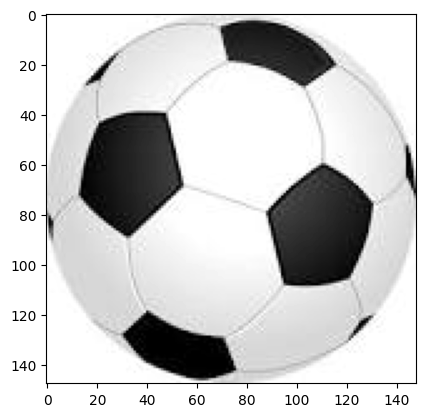

In [78]:
image = cv.imread('/content/download.jpeg', cv.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

In [79]:
def region_growing(image, seed, threshold):
    height, width = image.shape
    output = np.zeros_like(image, dtype=np.uint8)  # Initialize output image to black
    mean_intensity = image[seed[1], seed[0]]  # Get mean intensity from the seed pixel

    region = [seed]  # Initialize region with seed
    output[seed[1], seed[0]] = 255  # Mark seed pixel in output as white

    while region:
        x, y = region.pop(0)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:  # Skip the seed pixel
                    continue
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height:
                    intensity = image[ny, nx]
                    if output[ny, nx] == 0:  # Not already in region
                        if abs(int(intensity) - int(mean_intensity)) < threshold:
                            output[ny, nx] = 255  # Add to output region (white)
                            region.append((nx, ny))  # Add to growing region

    return output


In [80]:
def split_and_merge(image, threshold):
    height, width = image.shape
    labels = np.zeros_like(image, dtype=np.int32)
    current_label = 1

    # Split into regions (simple grid-based approach)
    for y in range(0, height, 10):  # Adjust size as needed
        for x in range(0, width, 10):
            sub_image = image[y:y+10, x:x+10]
            mean_sub = np.mean(sub_image)
            for dy in range(10):
                for dx in range(10):
                    if (y + dy < height and x + dx < width):
                        if abs(int(image[y + dy, x + dx]) - mean_sub) > threshold:
                            labels[y + dy, x + dx] = -1  # Mark for splitting
                        else:
                            labels[y + dy, x + dx] = current_label
            current_label += 1

    # Merge regions (simple merging)
    for label in np.unique(labels):
        if label > 0:
            region_mask = (labels == label)
            if np.sum(region_mask) > 10:  # Arbitrary merge condition
                labels[region_mask] = 0  # Mark for merging

    return labels

In [81]:
def split_image(image, threshold):
    """Split the image into quadrants based on a threshold."""
    if image.shape[0] <= threshold or image.shape[1] <= threshold:
        return [image]  # Return the image if it's smaller than the threshold

    mid_row = image.shape[0] // 2
    mid_col = image.shape[1] // 2

    # Split the image into four quadrants
    top_left = image[:mid_row, :mid_col]
    top_right = image[:mid_row, mid_col:]
    bottom_left = image[mid_row:, :mid_col]
    bottom_right = image[mid_row:, mid_col:]

    return split_image(top_left, threshold) + split_image(top_right, threshold) + \
           split_image(bottom_left, threshold) + split_image(bottom_right, threshold)

def merge_images(images):
    """Merge the list of images into one image."""
    if len(images) == 1:
        return images[0]

    # Determine the shape of the merged image
    total_height = sum(img.shape[0] for img in images)
    total_width = max(img.shape[1] for img in images)

    merged_image = np.zeros((total_height, total_width), dtype=np.uint8)
    current_height = 0

    for img in images:
        merged_image[current_height:current_height + img.shape[0], :img.shape[1]] = img
        current_height += img.shape[0]

    return merged_image

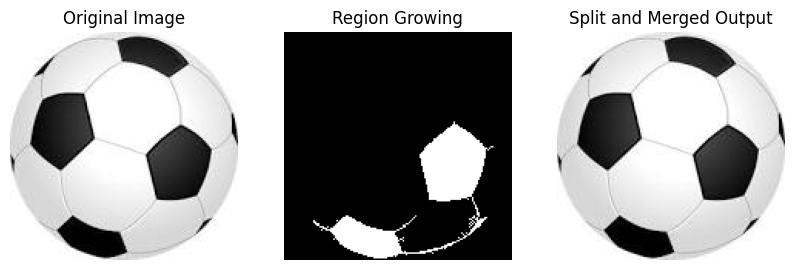

In [82]:
seed_pixel = (100, 100)  # Example seed position (adjust as needed)
threshold = 15  # Example threshold

# Apply Region Growing
growing_output = region_growing(image, seed_pixel, 175)

# Apply Split and Merge
split_images = split_image(image, threshold=150)
merged_image = merge_images(split_images)

# Display outputs
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Region Growing')
plt.imshow(growing_output, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Split and Merged Output')
plt.imshow(merged_image, cmap='gray')
plt.axis('off')

plt.show()
